## 34757 Unmanned autonomous systems

![image](ex5_1_2.png)

In [ ]:
import sympy as sp

# Ex 5.1

t = sp.symbols('t')
a0, a1, a2, a3, a4, a5 = sp.symbols('a0:6')

# polynomial and derivatives
x     = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5
xdot  = sp.diff(x, t)
xddot = sp.diff(xdot, t)

eqs = [
    sp.Eq(x.subs(t, 0), 0),      # x(0)=0
    sp.Eq(xdot.subs(t, 0), 0),   # ẋ(0)=0
    sp.Eq(xddot.subs(t, 0), 0),  # ẍ(0)=0
    sp.Eq(x.subs(t, 1), 1),      # x(1)=1
    sp.Eq(xdot.subs(t, 1), 0),   # ẋ(1)=0
    sp.Eq(xddot.subs(t, 1), 0),  # ẍ(1)=0
]

solution = sp.solve(eqs, [a0, a1, a2, a3, a4, a5], dict=True)[0]
print(solution)
print(sp.expand(x.subs(solution)))

{a0: 0, a1: 0, a2: 0, a3: 10, a4: -15, a5: 6}
6*t**5 - 15*t**4 + 10*t**3


Ex 5.1
$$
x(t) = 6 t^{5} - 15 t^{4} + 10 t^{3}
$$

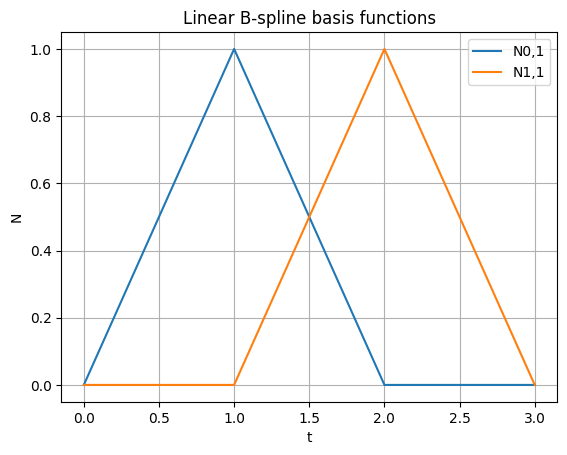

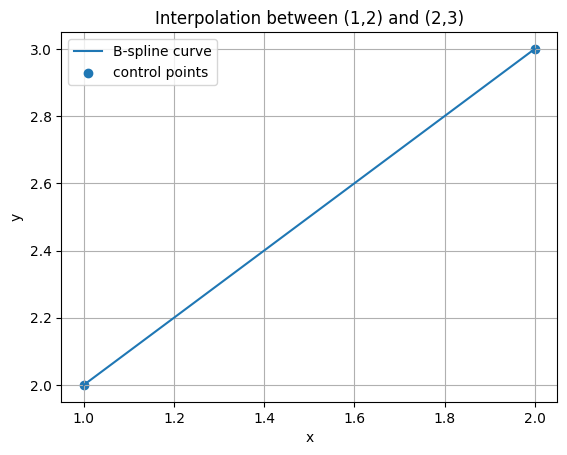

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ex 5.2

def cox_de_boor(t, i, p, knots):
    if p == 0:
        return 1.0 if knots[i] <= t < knots[i+1] else 0.0
    left_denom = knots[i+p] - knots[i]
    right_denom = knots[i+p+1] - knots[i+1]
    left = 0.0
    right = 0.0
    if left_denom:
        left = (t - knots[i]) / left_denom * cox_de_boor(t, i, p-1, knots)
    if right_denom:
        right = (knots[i+p+1] - t) / right_denom * cox_de_boor(t, i+1, p-1, knots)
    return left + right

knots = np.array([0,1,2,3])
t_vals = np.linspace(0,3,400)
N0 = np.array([cox_de_boor(t,0,1,knots) for t in t_vals])
N1 = np.array([cox_de_boor(t,1,1,knots) for t in t_vals])

plt.plot(t_vals,N0,label='N0,1')
plt.plot(t_vals,N1,label='N1,1')
plt.xlabel('t')
plt.ylabel('N')
plt.title('Linear B-spline basis functions')
plt.legend()
plt.grid(True)
plt.show()

P = np.array([[1.,2.],[2.,3.]]) # our points
t_curve = np.linspace(1,2,200)
curve = np.zeros((t_curve.size,2))
for k,tc in enumerate(t_curve):
    n0 = cox_de_boor(tc,0,1,knots)
    n1 = cox_de_boor(tc,1,1,knots)
    curve[k] = n0*P[0] + n1*P[1]

plt.plot(curve[:,0],curve[:,1],label='B-spline curve')
plt.scatter(P[:,0],P[:,1],label='control points')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Interpolation between (1,2) and (2,3)')
plt.legend(); plt.grid(True)
plt.show()


![image](ex5_3.png)

In [12]:
import numpy as np

def rotation_matrix_from_z_and_yaw_zxy(zB, psi):
    """
    Construct a DCM R_B (columns = body axes expressed in world coords)
    from a body z-axis 'zB' and a yaw angle 'psi' using the Z-X-Y Euler
    convention, as described by Mellinger and Kumar (2011).

    Parameters
    ----------
    zB  : array_like, shape (3,)
          Desired body z-axis in world frame (need not be unit length).
    psi : float
          Yaw angle (rad) about world Z.

    Returns
    -------
    R_B : ndarray, shape (3, 3)
          Direction-cosine matrix.
    """
    # Ensure zB is a unit vector
    zB = np.asarray(zB, dtype=float)
    if np.linalg.norm(zB) > 1e-6:
        zB /= np.linalg.norm(zB)
    else:
        # Handle zero vector input
        zB = np.array([0., 0., 1.])

    # In the Z-X-Y convention, the body y-axis is constructed to be
    # perpendicular to the desired body z-axis (zB) and the yawed
    # world x-axis (xC).
    xC = np.array([np.cos(psi), np.sin(psi), 0.0])

    # If zB is (almost) parallel to xC, the cross product will be near zero.
    # This is a singularity. To handle it, we choose an orthogonal
    # horizontal axis for the cross product.
    if abs(np.dot(zB, xC)) > 0.99:
        # Use the yawed y-direction as the reference instead
        xC = np.array([-np.sin(psi), np.cos(psi), 0.0])

    # Complete the right-handed frame
    yB = np.cross(zB, xC)
    yB /= np.linalg.norm(yB)
    xB = np.cross(yB, zB) # already unit length

    R_B = np.column_stack((xB, yB, zB))
    return R_B


def rotation_matrix_from_z_and_yaw_zyx(zB, psi):
    """
    Construct a DCM R_B (columns = body axes expressed in world coords)
    from a body z-axis 'zB' and a yaw angle 'psi' using the Z-Y-X Euler
    convention.

    Parameters
    ----------
    zB  : array_like, shape (3,)
          Desired body z-axis in world frame (need not be unit length).
    psi : float
          Yaw angle (rad) about world Z. This defines the heading of the
          body's x-axis projected onto the world XY-plane.

    Returns
    -------
    R_B : ndarray, shape (3, 3)
          Direction-cosine matrix.
    """
    # Ensure zB is a unit vector
    zB = np.asarray(zB, dtype=float)
    if np.linalg.norm(zB) > 1e-6:
        zB /= np.linalg.norm(zB)
    else:
        # Handle zero vector input
        zB = np.array([0., 0., 1.])

    # In the Z-Y-X convention, the body x-axis is constructed to be
    # perpendicular to the desired body z-axis (zB) and the yawed
    # world y-axis (yC).
    yC = np.array([-np.sin(psi), np.cos(psi), 0.0])
    
    # If zB is (almost) parallel to yC, the cross product will be near zero.
    # This is a singularity (gimbal lock, ~90 deg pitch).
    # We can resolve this by choosing an orthogonal horizontal axis for the
    # cross product.
    if abs(np.dot(zB, yC)) > 0.99:
        # Use the yawed x-direction as the reference instead
        ref_vec = np.array([np.cos(psi), np.sin(psi), 0.0])
        xB = np.cross(ref_vec, zB)
    else:
        xB = np.cross(yC, zB)

    xB /= np.linalg.norm(xB)

    # The body y-axis completes the right-handed frame.
    yB = np.cross(zB, xB) # already unit length

    R_B = np.column_stack((xB, yB, zB))
    return R_B


# --- Example Usage ---
psi = 0.7                                    # yaw = 40.1 deg
zB  = np.array([0.2, 0.3, 0.93])             # some tilt

# Original Z-X-Y convention from the paper
R_zxy = rotation_matrix_from_z_and_yaw_zxy(zB, psi)

# New Z-Y-X convention
R_zyx = rotation_matrix_from_z_and_yaw_zyx(zB, psi)

print("--- Z-X-Y Convention (Mellinger 2011) ---")
print("Rotation matrix R_B:\n", R_zxy)
print("\n")
print("--- Z-Y-X Convention ---")
print("Rotation matrix R_B:\n", R_zyx)

--- Z-X-Y Convention (Mellinger 2011) ---
Rotation matrix R_B:
 [[ 0.74133623 -0.64048072  0.20051196]
 [ 0.57560588  0.7604055   0.30076794]
 [-0.34510646 -0.10755431  0.93238061]]


--- Z-Y-X Convention ---
Rotation matrix R_B:
 [[ 0.71677963 -0.66784872  0.20051196]
 [ 0.60373516  0.73826994  0.30076794]
 [-0.34889943 -0.09452821  0.93238061]]
